In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import piv_fun as piv
import pof_piv as piv_old
import cv2 as cv
from numba import njit

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
margins_all = [[48, 496-443, 0, 0], 
           [60, 496-452, 0, 0],
           [10, 496-480, 0, 0],
           [0, 0, 128, 0]]

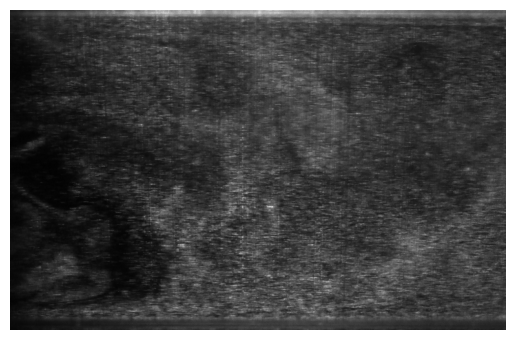

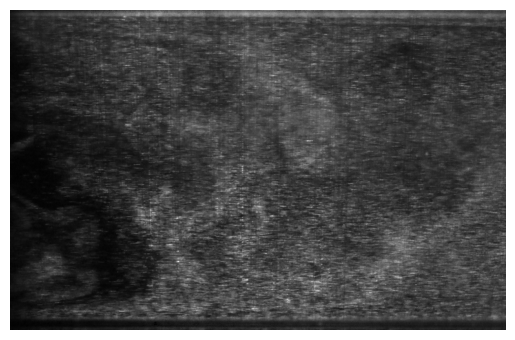

In [20]:
nr_position = 3
nr_series = 2
directory = 'piv_examples/pos' + str(nr_position) + '-' + str(nr_series) + '/'
margins = margins_all[nr_position - 1]

frame_rate = 40000
max_shift_px = 100
slice_ct = 8
window_ct = (24, 32)
sum_rows = True
plot_flow_field = True
valid_angles = [np.pi / 4, 3 * np.pi / 4]

images_withbg = piv.read_image_directory(directory, image_type='tif')
background = cv.imread(f'data/backgrounds/pos{nr_position}-{nr_series}.tif', cv.IMREAD_GRAYSCALE).astype(np.float64)

images = images_withbg - background

images[images < 0] = 0

# Show image without axes
plt.imshow(images_withbg[1], cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(images[0], cmap='gray')
plt.axis('off')
plt.show()
nr_images = 2

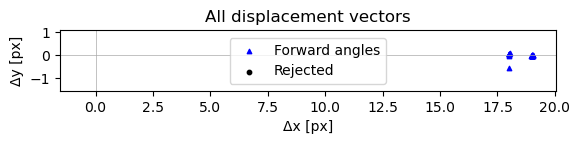

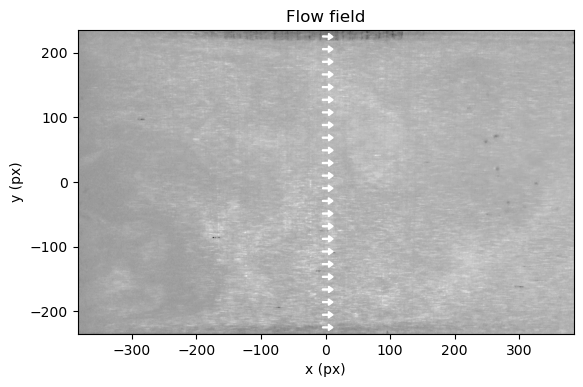

In [40]:
_,_ = piv.optical_flow(images, 8, (24, 32), 100, margins=margins, sum_rows=True, background=background, do_flow_plot=True, valid_angles=valid_angles, do_displ_plot=True)

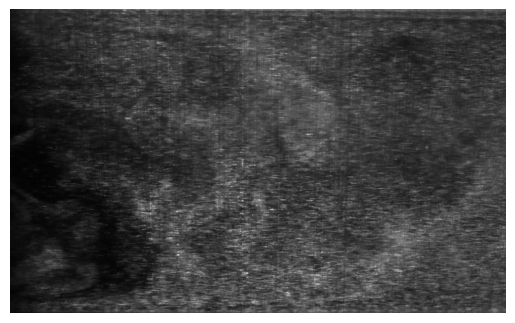

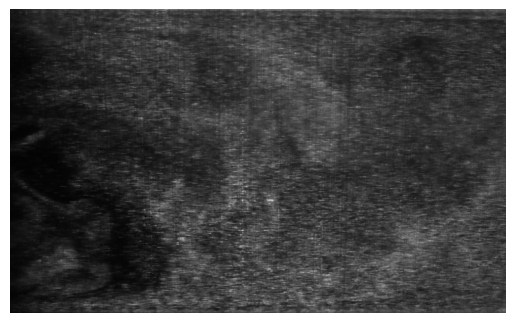

In [22]:
# Cut off a number of pixels in each direction given by margins
images_crop = images[:, margins[0]:(images.shape[1] - margins[1]),
              margins[2]:(images.shape[2] - margins[3])]

# In the cropped images, calculate the center of each window
window_size = (images_crop[0].shape /
               np.array([window_ct[0], window_ct[1]]))
window_y = np.arange(window_size[0] / 2, images_crop[0].shape[0],
                     window_size[0])
window_x = np.arange(window_size[1] / 2, images_crop[0].shape[1],
                     window_size[1]) \
    if not sum_rows else [images_crop[0].shape[1] / 2]
window_centers = np.array([[[y, x] for x in window_x] for y in window_y])

# Pre-allocate displacements array
displacements = np.empty(
        (nr_images - 1, window_ct[0], window_ct[1], 2), dtype=np.float64) \
    if not sum_rows else np.empty(
        (nr_images - 1, window_ct[0], 1, 2), dtype=np.float64)

# Show cropped images
plt.imshow(images_crop[0], cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(images_crop[1], cmap='gray')
plt.axis('off')
plt.show()

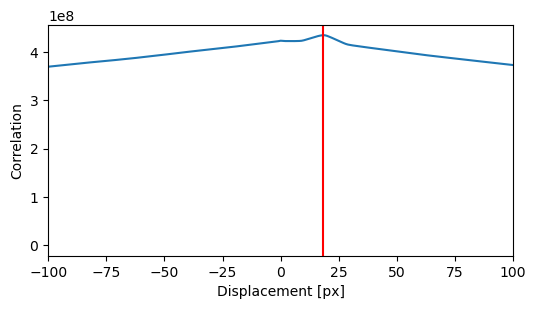

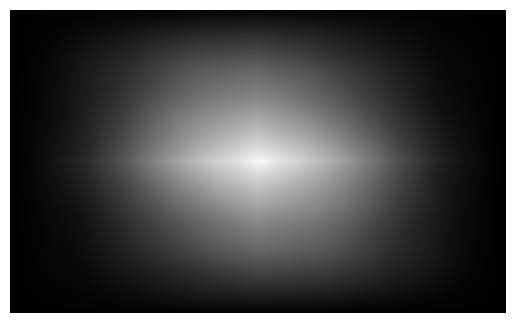

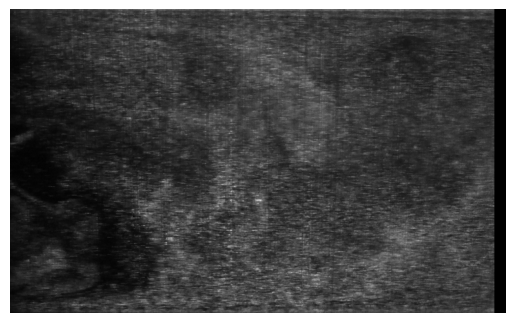

In [28]:
c = 0

# Calculate the displacement of the entire image
corr_init = sig.correlate(images_crop[c + 1], images_crop[c])
hor_disp_init = piv.displacement_1d(corr_init, max_disp=max_shift_px, plot=True)

# Otherwise, turn it into an integer
hor_disp_init = int(hor_disp_init)

# If there is movement, shift the second image to match the first
images_shift = piv.shift_displaced_image(images_crop[c:(c + 2)],
                                     hor_disp_init)

# Show the correlation map
plt.imshow(corr_init, cmap='gray')
plt.axis('off')
plt.show()

# Show the shifted image 1
plt.imshow(images_shift[1], cmap='gray')
plt.axis('off')
plt.show()
    

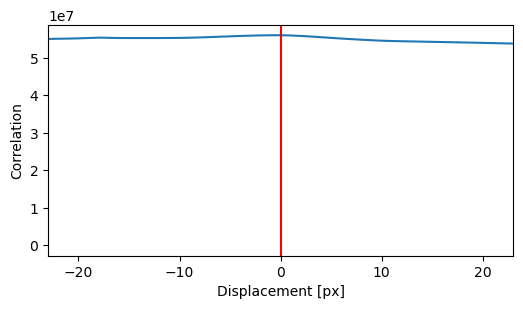

IndexError: index 1 is out of bounds for axis 2 with size 1

In [31]:
# Pre-allocate displacements array
displacements = np.empty(
        (nr_images - 1, window_ct[0], window_ct[1], 2), dtype=np.float64) \
    if not sum_rows else np.empty(
        (nr_images - 1, window_ct[0], 1, 2), dtype=np.float64)

# Divide the image into slices
slice_set = np.array_split(images_shift, slice_ct, axis=1)
# displacements = np.empty((window_ct[0], window_ct[1], 2),
#                          dtype=np.float64) if not sum_rows \
#     else np.empty((window_ct[0], 1, 2), dtype=np.float64)
displacements[c, :, :, :] = np.nan


# Get the horizontal displacement in the slices
for j, slices in enumerate(slice_set):

    # Maximum displacement will be limited further,
    # with a minimum of 10 for peak detection purposes
    max_disp = hor_disp_init + 5 if hor_disp_init > 5 else 10
    # max_disp = max_disp

    # If the initial displacement was larger than 2 px, we will
    # prevent the next search from flipping back onto the original
    # peak at 0 movement
    ignore_only_if_mult = False if hor_disp_init > 2 else True

    # Calculate the displacement in the slice
    corr_slice = sig.correlate(slices[1], slices[0])
    hor_disp_slice = piv.displacement_1d(
            corr_slice, ignore_disp=-hor_disp_init,
            ignore_only_if_mult=ignore_only_if_mult,
            max_disp=max_disp, plot=True)

    # If this gives no result, there is no movement in this slice
    if np.isnan(hor_disp_slice):
        continue

    # Shift the second slice to match the first
    slices_shift = piv.shift_displaced_image(slices, hor_disp_slice)

    # Plot shifted slice
    

    # THIRD PASS
    # Divide the slice into windows
    window_set = np.array_split(slices_shift,
                                window_ct[0] // slice_ct,
                                axis=1)
    window_set = [np.array_split(row, window_ct[1], axis=2)
                  for row in window_set]

    # For each window, calculate the correlation maps
    corr_set = [[sig.correlate(window[1], window[0]) for window in row]
                for row in window_set]

    # if sum_rows:
    #     # Sum the correlation windows along the rows
    #     corr_set = [np.sum(row, axis=0, keepdims=True)
    #                 for row in corr_set]

    # Calculate the displacement from the 2d correlation maps
    disp_set = [[piv.displacement_2d(corr, max_disp=max_disp)
                 for corr in row] for row in corr_set]

    # Put the displacements in the correct place in the array
    for j_w, row in enumerate(disp_set):
        for i, disp in enumerate(row):
            displacements[c, j_w + j * window_ct[0] // slice_ct, i, :] \
                = disp + [0, hor_disp_slice + hor_disp_init]

    # PLOTTING ACTION
    # Plot the displacement vectors
    _, _ = piv.plot_displacements(displacements,
                              highlight_radius_range=[1e-20, np.inf],
                              highlight_angle_range=valid_angles,
                              legend=['Forward angles', 'Rejected'])

    # If the average horizontal displacement is larger than 1 px,
    # also replace displacements not in the valid angle range
    if np.abs(np.nanmean(displacements[c, :, :, 1])) > 1:
        valid_mask = piv.filter_displacements(displacements[c, :, :, :],
                                          angle_range=valid_angles,
                                          radius_range=[1, np.inf])
        displacements[c, ~valid_mask] = np.nan

    # Plot flow field
    _, _ = piv.plot_flow_field(displacements[c, :, :, :], window_centers,
                           arrow_scale=1,
                           arrow_color='white',
                           background=images_crop[0])

    # Print mean horizontal velocity
    print(np.nanmean(displacements[c, :, :, 1]))

(array([[[[-4.49939017e-02,  1.80110383e+01]],
 
         [[-4.22482815e-04,  1.80099260e+01]],
 
         [[ 2.12750211e-02,  1.79976148e+01]],
 
         [[-2.24250621e-02,  1.90167878e+01]],
 
         [[-2.06202988e-02,  1.90229768e+01]],
 
         [[-1.05701098e-02,  1.90225687e+01]],
 
         [[-2.48631556e-02,  1.90118716e+01]],
 
         [[-9.46477561e-03,  1.89999122e+01]],
 
         [[-2.01681468e-02,  1.89959673e+01]],
 
         [[ 2.40626132e-02,  1.80028957e+01]],
 
         [[ 2.12707224e-02,  1.79988214e+01]],
 
         [[ 2.77877700e-02,  1.79978098e+01]],
 
         [[-3.11855890e-02,  1.90056745e+01]],
 
         [[-1.12539343e-02,  1.89927251e+01]],
 
         [[-2.58868860e-02,  1.89996060e+01]],
 
         [[-2.48369199e-02,  1.89885883e+01]],
 
         [[-2.69921736e-02,  1.90188330e+01]],
 
         [[-2.88042233e-02,  1.90043007e+01]],
 
         [[-2.91946738e-02,  1.89797573e+01]],
 
         [[-2.18567078e-02,  1.90052464e+01]],
 
         [[-1.998637

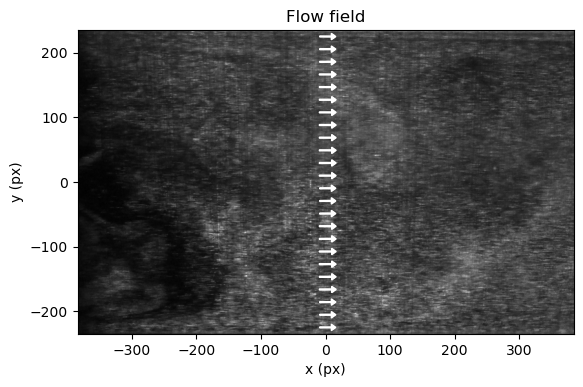

In [6]:



# Load a few example images
images = piv.read_image_directory(directory, image_type='tif')

# Load background
background = cv.imread('data/backgrounds/pos' + str(nr_position) + '-' + str(nr_series) + '.tif', cv.IMREAD_GRAYSCALE)

piv.optical_flow(images, 8, (24, 32), 100, margins=margins, sum_rows=True, background=background, do_flow_plot=True, valid_angles=valid_angles)

In [49]:
images_video = piv.read_image_directory('data/pos4-4', image_type='tif', timing=True)
background = cv.imread('data/backgrounds/pos4-4.tif', cv.IMREAD_GRAYSCALE)

# Set options
nr_position = 4 
max_shift_px = 100
slice_ct = 8
window_ct = (24, 32)

# From array
margins = margins_all[nr_position - 1]

# Run PIV
displacements, window_centers = piv.optical_flow(images_video, slice_ct, window_ct, max_shift_px, use_guess=True,
                                 margins=margins, sum_rows=False, background=background,
                                 valid_angles=[np.pi / 4, 3 * np.pi / 4],
                                 timing=True)

Optical flow: 100%|██████████| 20994/20994 [35:45<00:00,  9.78it/s]


(0.0, 2000.0)

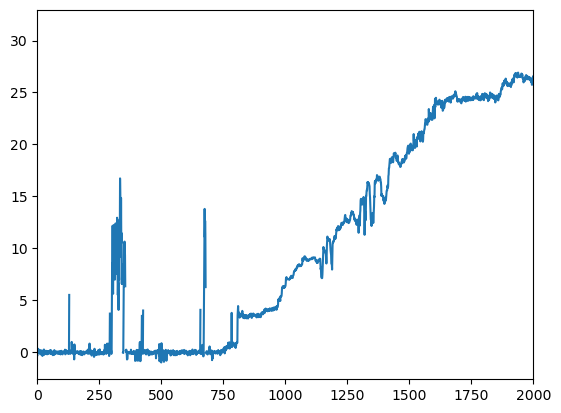

In [52]:
# Calculate the mean displacement
mean_displacements = piv.mean_displacement(displacements, comp='x', av_dir='all')

# Plot the mean displacement over time
fig, ax = plt.subplots()
ax.plot(mean_displacements.flatten())
ax.set_xlim(0, 2000)

Optical flow: 100%|██████████| 750/750 [00:46<00:00, 15.98it/s]


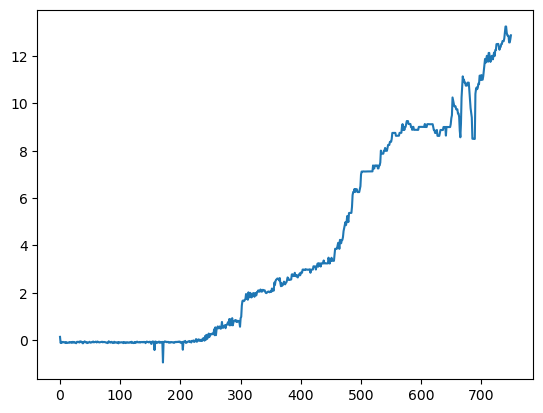

In [33]:
images_video = piv.read_image_directory('data/pos4-4', image_type='tif', timing=True, file_range=(500, 1250))
background = cv.imread('data/backgrounds/pos4-4.tif', cv.IMREAD_GRAYSCALE)

# Set options
nr_position = 4
max_shift_px = 100
slice_ct = 8
window_ct = (24, 32)

# From array
margins = margins_all[nr_position - 1]

# Run PIV
displacements, window_centers = piv.optical_flow(images_video, slice_ct, window_ct, max_shift_px, use_guess=True,
                                 margins=margins, sum_rows=True, background=background,
                                 valid_angles=[np.pi / 4, 3 * np.pi / 4],
                                 timing=True)

# Calculate the mean displacement
mean_displacements = piv.mean_displacement(displacements, comp='x', av_dir='all')

# Plot the mean displacement over time
fig, ax = plt.subplots()
ax.plot(mean_displacements.flatten())
# ax.set_xlim(0, 2000)
# ax.set_ylim(0, 35)

Optical flow: 100%|██████████| 1500/1500 [01:31<00:00, 16.47it/s]


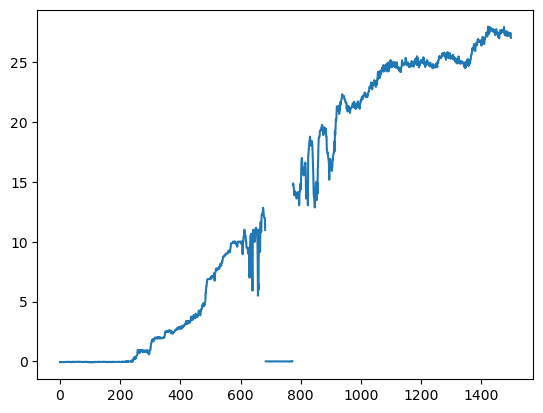

In [18]:
images_video = piv.read_image_directory('data/pos4-4', image_type='tif', timing=True, file_range=(1100, 1250))
background = cv.imread('data/backgrounds/pos4-4.tif', cv.IMREAD_GRAYSCALE)

# Set options
nr_position = 1
max_shift_px = 100
slice_ct = 8
window_ct = (24, 32)

# From array
margins = margins_all[nr_position - 1]

# Run PIV
displacements, window_centers = piv.optical_flow(images_video, slice_ct, window_ct, max_shift_px, use_guess=True,
                                 margins=margins, sum_rows=True, background=background,
                                 valid_angles=[np.pi / 4, 3 * np.pi / 4],
                                 timing=True)

# Calculate the mean displacement
mean_displacements = piv.mean_displacement(displacements, comp='x', av_dir='all')

# Plot the mean displacement over time
fig, ax = plt.subplots()
ax.plot(mean_displacements.flatten())
# ax.set_xlim(0, 2000)
# ax.set_ylim(0, 35)